In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python langchain_nvidia_ai_endpoints

In [3]:
!pip install -U -q "google-genai>=1.16.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 kB 8.3 MB/s eta 0:00:00


In [4]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [5]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [6]:
# from typing_extensions import TypedDict
# from typing import  Annotated, List, Optional, Literal
# from pydantic import BaseModel, Field
# from pydantic.fields import FieldInfo
# import operator
# class OutputState(TypedDict):
#   genre:str
#   synopsis:str
#   theme: str
#   title: str
#   protoganist: str
#   tone: str

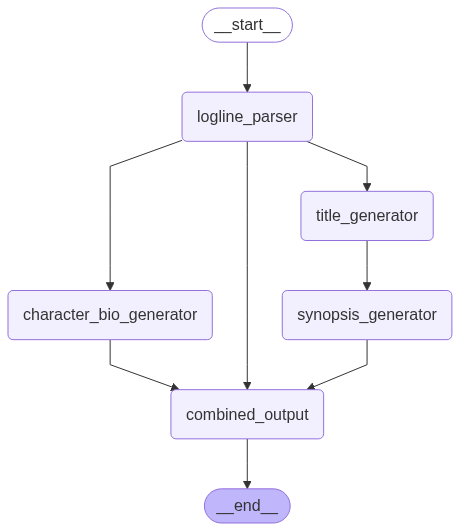

{'logline': 'A young wizard must find a magical artifact to save his world from an evil sorcerer.', 'logline_response': '```json\n{\n  "genre": "Fantasy",\n  "themes": [\n    "Quest",\n    "Good vs. Evil",\n    "Heroism",\n    "Responsibility"\n  ],\n  "protagonist": {\n    "type": "Young Wizard",\n    "goal": "Find a magical artifact"\n  },\n  "conflict": {\n    "primary": "Locate a magical artifact to save the world",\n    "antagonist": "Evil sorcerer",\n    "stakes": "World\'s destruction"\n  },\n  "tone": "Urgent, Epic, Adventurous"\n}\n```', 'title_response': 'The Sunstone Prophecy', 'synopsis_response': "The world teeters on the brink of eternal night, threatened by the malevolent sorcerer, Kaelen, whose shadowy power grows with each passing day. The only hope lies in the ancient verses of 'The Sunstone Prophecy,' foretelling a legendary artifact capable of banishing Kaelen's darkness. Burdened by this daunting revelation, Lyra, a young wizard of untapped potential, is thrust fro

In [7]:
from langchain.prompts import PromptTemplate
from google import genai
from google.genai import types
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field
from pydantic.fields import FieldInfo
import operator

class GraphState(TypedDict):
  logline: str
  logline_response: str
  title_response: str
  synopsis_response: str
  character_bio_response: str

logline_parser_template = PromptTemplate(
  input_variables=["logline"],
  template=(
    "Role: You are a professional script development assistant.\n"
    "Task: Parse the following logline into its core elements.\n"
    "Logline: {logline}\n"
    "Format Constraints: Respond ONLY in JSON format with keys: genre, themes, protagonist, conflict, tone.\n"
    "Output Style: Clean, concise, and actionable."
  )
)

title_generator_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a script marketer.\n"
        "Task: Generate a compelling and memorable title for the script based on the parsed logline below.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a single title string.\n"
        "Output Style: Concise, attention-grabbing, genre-appropriate."
    )
)

synopsis_generator_template = PromptTemplate(
    input_variables=["parsed_logline", "title"],
    template=(
        "Role: You are an experienced screenwriter.\n"
        "Task: Write a 2–3 paragraph synopsis that captures beginning, middle, and end based on the parsed logline and title.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Title: {title}\n"
        "Format Constraints: Output as plain text with paragraphs.\n"
        "Output Style: Insightful, emotionally engaging, concise."
    )
)

character_bio_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a character development specialist.\n"
        "Task: Generate detailed bios for the major characters implied by the logline.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a JSON array. Each entry must include: name, role, motivation, character arc, quirks.\n"
        "Output Style: Structured, clear, character-driven."
    )
)

def logline_parser(state: GraphState):
  logline_response = client.models.generate_content(model="gemini-2.5-flash",contents=[logline_parser_template.format(logline=state["logline"])])
  return {"logline_response": logline_response.text}

def title_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title_response = client.models.generate_content(model="gemini-2.5-flash",contents=[title_generator_template.format(parsed_logline=parsed_logline)])
  return {"title_response": title_response.text}

def synopsis_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title = state['title_response']
  synopsis_response = client.models.generate_content(model="gemini-2.5-flash",contents=[synopsis_generator_template.format(parsed_logline=parsed_logline, title=title)])
  return {"synopsis_response": synopsis_response.text}

def character_bio_generator(state: GraphState):
  parsed_logline = state['logline_response']
  character_bio_response = client.models.generate_content(model="gemini-2.5-flash",contents=[character_bio_template.format(parsed_logline=parsed_logline)])
  return {"character_bio_response": character_bio_response.text}

def combined_output(state: GraphState):
  return state

g = StateGraph(GraphState)
g.add_node("logline_parser",logline_parser)
g.add_node("title_generator",title_generator)
g.add_node("synopsis_generator",synopsis_generator)
g.add_node("character_bio_generator",character_bio_generator)
g.add_node("combined_output",combined_output)
g.add_edge(START, "logline_parser")
g.add_edge("logline_parser", "title_generator")
g.add_edge("logline_parser", "character_bio_generator")
g.add_edge("title_generator", "synopsis_generator")
g.add_edge("synopsis_generator", "combined_output")
g.add_edge("character_bio_generator", "combined_output")
g.add_edge("logline_parser", "combined_output")
g.add_edge("combined_output", END)


graph = g.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Sample logline and initial state
sample_logline = "A young wizard must find a magical artifact to save his world from an evil sorcerer."
initial_state = {"logline": sample_logline}

# Invoke the graph
output = graph.invoke(initial_state)
print(output)

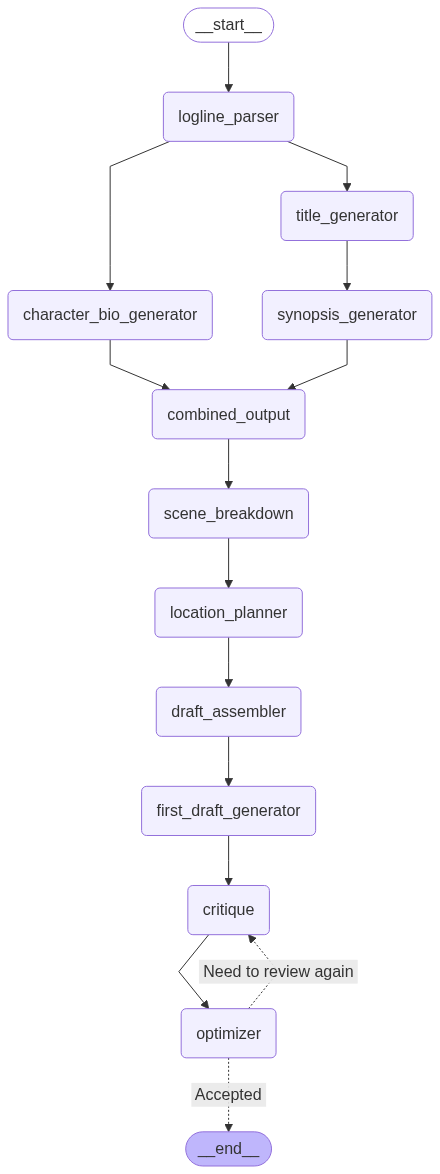

In [10]:
import re
class GraphState(TypedDict):
  logline: str
  logline_response: str
  title_response: str
  synopsis_response: str
  character_bio_response: str
  scenebreakdown: str
  locations: str
  draft_skeleton: str
  first_draft: str
  final_script_format: str
  critique_json: str
  revised_draft: str
  desired_changes: str

logline_parser_template = PromptTemplate(
  input_variables=["logline"],
  template=(
    "Role: You are a professional script development assistant.\n"
    "Task: Parse the following logline into its core elements.\n"
    "Logline: {logline}\n"
    "Format Constraints: Respond ONLY in JSON format with keys: genre, themes, protagonist, conflict, tone.\n"
    "Output Style: Clean, concise, and actionable."
  )
)

title_generator_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a script marketer.\n"
        "Task: Generate a compelling and memorable title for the script based on the parsed logline below.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a single title string.\n"
        "Output Style: Concise, attention-grabbing, genre-appropriate."
    )
)

synopsis_generator_template = PromptTemplate(
    input_variables=["parsed_logline", "title"],
    template=(
        "Role: You are an experienced screenwriter.\n"
        "Task: Write a 2–3 paragraph synopsis that captures beginning, middle, and end based on the parsed logline and title.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Title: {title}\n"
        "Format Constraints: Output as plain text with paragraphs.\n"
        "Output Style: Insightful, emotionally engaging, concise."
    )
)

character_bio_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a character development specialist.\n"
        "Task: Generate detailed bios for the major characters implied by the logline.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a JSON array. Each entry must include: name, role, motivation, character arc, quirks.\n"
        "Output Style: Structured, clear, character-driven."
    )
)

def logline_parser(state: GraphState):
  logline_response = client.models.generate_content(model="gemini-2.5-flash",contents=[logline_parser_template.format(logline=state["logline"])])
  return {"logline_response": logline_response.text}

def title_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title_response = client.models.generate_content(model="gemini-2.5-flash",contents=[title_generator_template.format(parsed_logline=parsed_logline)])
  return {"title_response": title_response.text}

def synopsis_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title = state['title_response']
  synopsis_response = client.models.generate_content(model="gemini-2.5-flash",contents=[synopsis_generator_template.format(parsed_logline=parsed_logline, title=title)])
  return {"synopsis_response": synopsis_response.text}

def character_bio_generator(state: GraphState):
  parsed_logline = state['logline_response']
  character_bio_response = client.models.generate_content(model="gemini-2.5-flash",contents=[character_bio_template.format(parsed_logline=parsed_logline)])
  return {"character_bio_response": character_bio_response.text}

def combined_output(state: GraphState):
  return state

scenebreakdown_template = PromptTemplate(
  input_variables=["title", "synopsis", "character_bios"],
  template=(
    "Role: You are a story architect.\n"
    "Task: Break down the story with Title: {title}, Synopsis: {synopsis}, Characters: {character_bios} into 8–12 key scenes.\n"
    "Format Constraints: Return a JSON array of objects with keys: scene_no, goal, stakes, summary.\n"
    "Output Style: Strategic, storyflow-oriented, prioritized."
  )
)
locations_template = PromptTemplate(
  input_variables=["scenebreakdown"],
  template=(
    "Role: You are a cinematic setting designer.\n"
    "Task: For each scene in the breakdown below, suggest 1–2 evocative locations/settings.\n"
    "Scene Breakdown JSON: {scenebreakdown}\n"
    "Format Constraints: Return a JSON array of objects with keys: scene_no, location_description.\n"
    "Output Style: Vivid, visual, mood-enhancing."
  )
)

draft_assembler_template = PromptTemplate(
    input_variables=["title", "synopsis_response", "character_bio_response", "scenebreakdown", "locations"],
    template=(
        "Role: You are a script organizer.\n"
        "Task: Combine the provided story components into a structured draft skeleton to guide scriptwriting.\n\n"
        "Title: {title}\n"
        "Synopsis: {synopsis}\n"
        "Characters JSON: {characters}\n"
        "Scenes JSON: {scenes}\n"
        "Locations JSON: {locations}\n\n"
        "Format: Return a single JSON object with keys:\n"
        " - title\n - synopsis\n - characters (as array)\n - scenes (array of objects with: scene_no, summary, location)\n"
        "Output Style: Clean, structured, and parseable."
    )
)

first_draft_template = PromptTemplate(
    input_variables=["draft_skeleton"],
    template=(
        "Role: You are a professional scriptwriter.\n"
        "Task: For each scene in the story skeleton below, write detailed action lines and dialogue.\n\n"
        "Draft Skeleton JSON: {draft_skeleton}\n\n"
        "Format: Return a JSON array where each element includes:\n"
        "- scene_no\n- action_lines\n- dialogue_script\n\n"
        "Output Style: Cinematic, emotionally engaging, consistent with character bios and tone."
    )
)

def scene_breakdown(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[scenebreakdown_template.format(
            title=state["title_response"],
            synopsis=state["synopsis_response"],
            character_bios=state["character_bio_response"]
        )]
    ).text
    return {"scenebreakdown": resp}

def location_planner(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[locations_template.format(
            scenebreakdown=state["scenebreakdown"]
        )]
    ).text
    return {"locations": resp}

def draft_assembler(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[
            draft_assembler_template.format(
                title=state["title_response"],
                synopsis=state["synopsis_response"],
                characters=state["character_bio_response"],
                scenes=state["scenebreakdown"],
                locations=state["locations"]
            )
        ]
    ).text
    return {"draft_skeleton": resp}

def first_draft_generator(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[first_draft_template.format(
            draft_skeleton=state["draft_skeleton"]
        )]
    ).text
    return {"first_draft": resp}

convert_script_format_template = PromptTemplate(
    input_variables=["first_draft"],
    template=(
        "Role: You are a script formatting specialist.\n"
        "Task: Convert the following script content, provided as a JSON array, into a standard readable writer's script format.\n"
        "Maintain all the action lines and dialogue exactly as they are in the JSON.\n"
        "Do NOT add, remove, or change any creative content (action, dialogue, characters, plot). Your ONLY task is formatting.\n"
        "JSON Script Content: {first_draft}\n\n"
        "Output Format: Use standard screenplay format. Scene headings (INT./EXT. LOCATION - DAY/NIGHT), action lines, character names (centered and capitalized), and dialogue.\n"
        "Do NOT include any additional commentary or markdown outside the script format."
    )
)
def convert_script_format(state: GraphState):
    revised_draft_json_str = state.get("first_draft", "")

    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[convert_script_format_template.format(
            revised_draft=revised_draft_json_str
        )]
    ).text
    return {"final_script_format": resp}

critique_template = PromptTemplate(
    input_variables=["title", "logline", "synopsis", "first_draft"],
    template=(
        "You are an expert script editor and film/TV story analyst.\n"
        "Given the following materials, produce: (A) a concise multi-criteria scorecard (1-10)\n"
        "for the categories: Relevance-to-logline, Story-structure & Pacing, Character-arc clarity,\n"
        "Dialogue & Voice, Stakes & Conflict, Originality, Marketability (is it genre-compatible),\n"
        "and Overall Score. (B) A short paragraph summary of the biggest 3 problems, and (C)\n"
        "Actionable revision bullets (3-6), each explicitly saying what to change and showing\n"
        "a one-line example rewrite when helpful.\n\n"
        "Title: {title}\n"
        "Logline: {logline}\n"
        "Synopsis:\n{synopsis}\n\n"
        "First Draft:\n{first_draft}\n\n"
        "Format constraints:\n- Start with a JSON object with keys: scores (dict), overall (number), problems (array), suggestions (array).\n- Then a short human-readable section titled 'Human Explanation' that expands the top problems.\n- Keep numeric scores strictly between 1 and 10.\n"
    )
)

optimizer_template = PromptTemplate(
    input_variables=["first_draft", "critique_json", "desired_changes"],
    template=(
        "You are an expert script rewriter. Given the original draft and the critique (as JSON),\n"
        "produce a revised draft that addresses the critique.\n\n"
        "Original Draft:\n{first_draft}\n\n"
        "Critique JSON:\n{critique_json}\n\n"
        "Desired changes (optional instructions): {desired_changes}\n\n"
        "Output constraints:\n- Return only the revised draft as plain text.\n- Make the draft coherent and keep length similar unless the critique suggests shortening or expanding.\n- Preserve any strongly-defined character names and major plot beats unless critique explicitly reworks them.\n"
    )
)

def evaluator(state: GraphState):
    title = state.get("title_response") or state.get("title") or "Untitled"
    logline = state.get("logline") or ""
    synopsis = state.get("synopsis_response") or state.get("synopsis") or ""
    first_draft = state.get("first_draft") or ""

    if not first_draft:
        return {"critique": "", "critique_json": "{\"error\": \"no_draft\"}", "scores": {}}

    prompt = critique_template.format(title=title, logline=logline, synopsis=synopsis, first_draft=first_draft)

    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt]
    ).text

    import json, re
    m = re.search(r"\{\s*\"scores\".*?\}\s*", resp, re.S)
    critique_json = None
    scores = {}
    if m:
        try:
            critique_json = m.group(0)
            parsed = json.loads(critique_json)
            scores = parsed.get("scores", parsed.get("scorecard", {}))
        except Exception:
            critique_json = None
            scores = {}

    # Fallback: keep raw text if JSON parse failed
    if not critique_json:
        critique_json = "{\"error_parsing\": true, \"raw\": " + json.dumps(resp[:1000]) + "}"

    return {"critique": resp, "critique_json": critique_json, "scores": scores}

def optimizer_node(state: dict, desired_changes: str = ""):
    """Creates a revised draft using the critique stored in state['critique_json'].
    Returns: {'revised_draft': str}
    """
    first_draft = state.get("first_draft") or ""
    critique_json = state.get("critique_json") or state.get("critique") or ""

    prompt = optimizer_template.format(first_draft=first_draft, critique_json=critique_json, desired_changes=desired_changes)

    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt]
    ).text

    return {"revised_draft": resp}

scoring_template = PromptTemplate(
    input_variables=["revised_draft"],
    template=("Act as a bunch of reviewers who scores/rates the script we have. The revised script written : {revised_draft} you should rate the script on the scale of percentage(% out of 100)"
               "Rate it as different persons perspectives and give out the average number"
               "Just return the number"
               "Donot explain or do anything..just return the number")
)
def scoring(state: GraphState):
    revised_draft = state.get("revised_draft") or ""
    prompt = scoring_template.format(revised_draft=revised_draft)
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt]
    ).text
    m=re.search(r"(\d{1,3}(?:\.\d+)?)", resp)
    score = float(m.group(1))
    score = max(0.0, min(100.0, score))
    if score>=75.0:
      return "Accepted"
    else:
      state["first_draft"] = revised_draft
      return "Need to review again"

g = StateGraph(GraphState)
g.add_node("logline_parser",logline_parser)
g.add_node("title_generator",title_generator)
g.add_node("synopsis_generator",synopsis_generator)
g.add_node("character_bio_generator",character_bio_generator)
g.add_node("combined_output",combined_output)
g.add_node("scene_breakdown",scene_breakdown)
g.add_node("location_planner",location_planner)
g.add_node("draft_assembler",draft_assembler)
g.add_node("first_draft_generator", first_draft_generator)
# g.add_node("convert_script_format",convert_script_format)
g.add_node("critique",evaluator)
g.add_node("optimizer",optimizer_node)

g.add_edge(START, "logline_parser")
g.add_edge("logline_parser", "title_generator")
g.add_edge("logline_parser", "character_bio_generator")
g.add_edge("title_generator", "synopsis_generator")
g.add_edge("synopsis_generator", "combined_output")
g.add_edge("character_bio_generator", "combined_output")
# g.add_edge("logline_parser", "combined_output")
g.add_edge("combined_output", "scene_breakdown")
g.add_edge("scene_breakdown", "location_planner")
g.add_edge("location_planner", "draft_assembler")
g.add_edge("draft_assembler", "first_draft_generator")
g.add_edge("first_draft_generator", "critique")
g.add_edge("critique", "optimizer")
# g.add_edge("optimizer", END)
g.add_conditional_edges("optimizer",scoring,{"Accepted":END,"Need to review again":"critique"})
graph = g.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
result = graph.invoke({"logline": "A young genius prodigy intrested in robotics tries to be a superhero and when an evil strikes,he fights it along with his friends and saves the city."})
print(result["revised_draft"])

```json
[
  {
    "scene_no": 1,
    "action_lines": "EXT. SOLARIS CITY SKYLINE - DAY\n\nThe cityscape of SOLARIS CITY gleams under a perpetually clear sky. Aerial trams glide silently along glowing sky-lanes, connecting towering, organically shaped skyscrapers adorned with vibrant, vertical farms. It's a vision of pristine, clean energy, almost too perfect.\n\nINT. KAI'S HYPER-TECH LOFT WORKSHOP - DAY\n\nSunlight streams through the floor-to-ceiling windows of KAI NAKAMURA's (20s) multi-level workshop. Holographic schematics shimmer in the air, depicting intricate energy conduits. A bespoke ROBOTIC ARM whirs, meticulously assembling tiny components. The air hums with perpetual invention.\n\nKAI, his hands smudged with grease, gestures wildly with a microchip, a half-empty mug of hyper-caffeinated tea steaming beside him. His eyes, usually focused on his work, are alight with an almost childlike enthusiasm. He fidgets, ceaselessly twisting a resistor between his fingers, his thoughts t

In [ ]:
result = graph.invoke({"logline": "A young genius prodigy intrested in robotics tries to be a superhero and when an evil strikes,he fights it along with his friends and saves the city."})
print(result["first_draft"])

```json
[
  {
    "scene_no": 1,
    "action_lines": "FADE IN:\n\nINT. UNIVERSITY R&D HUB - DAY\n\nSunlight streams through the vast, multi-level glass walls of a cutting-edge university research and development hub. It's a marvel of 'Silicon Valley' architecture, with a central atrium allowing glimpses into various specialized labs.\n\nDown a flight of stairs, in a sprawling, chaotic yet organized robotics haven, ELIJAH \"ELI\" VANCE (20s, brilliant, perpetually messy lab coat stained with coffee, fidgeting with a custom multi-tool) is deep in concentration. Whirring servos and the gentle hum of power emanate from a complex PROTOTYPE DRONE, suspended mid-air by holographic displays.\n\nELI (V.O.)\n(Muttering)\n…optimal thruster vectoring at twenty-three degrees, accounting for atmospheric pressure differentials. Standard aerodynamic equations are so… limiting. Aren't they, little guy?\n\nEli adjusts a microscopic component with the precision of a surgeon, his brow furrowed in intense 

Can add to the graph to make it a text script

In [ ]:
convert_script_format_template = PromptTemplate(
    input_variables=["revised_draft"],
    template=(
        "Role: You are a script formatting specialist.\n"
        "Task: Convert the following script content, provided as a JSON array, into a standard readable writer's script format.\n"
        "Maintain all the action lines and dialogue exactly as they are in the JSON.\n"
        "Do NOT add, remove, or change any creative content (action, dialogue, characters, plot). Your ONLY task is formatting.\n"
        "JSON Script Content: {revised_draft}\n\n"
        "Output Format: Use standard screenplay format. Scene headings (INT./EXT. LOCATION - DAY/NIGHT), action lines, character names (centered and capitalized), and dialogue.\n"
        "Do NOT include any additional commentary or markdown outside the script format."
    )
)
def convert_script_format(state: GraphState):
    # Assuming revised_draft contains the JSON string of the script
    revised_draft_json_str = state.get("revised_draft", "")

    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[convert_script_format_template.format(
            revised_draft=revised_draft_json_str
        )]
    ).text
    return {"final_script_format": resp}